
- traditional vae에서는 latent space가 gaussian distribution으로부터 sampling됨. 
- 일반적으로 gradient descent로 그러한 분포를 학습하는 건 어렵다. 
- VQ-VAE 는 discrete latent space 를 통해 optimization 과정을 더 수월하게 해줌!

- 핵심 개념은 codebook. 

### Codebook 이란 continuous embedding(key)와 encoded output간의 거리계산을 통해 형성.




In [3]:
!pip install -q tensorflow-probability

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
#tensoflow_probability 형성
import tensorflow_probability as tfp
import tensorflow as tf

VectorQuantizer layer  

[VQ-VAE : deeper to equation](https://velog.io/@crosstar1228/%EC%83%9D%EC%84%B1%EB%AA%A8%EB%8D%B8VQ-VAE-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-Deeper-to-equation)

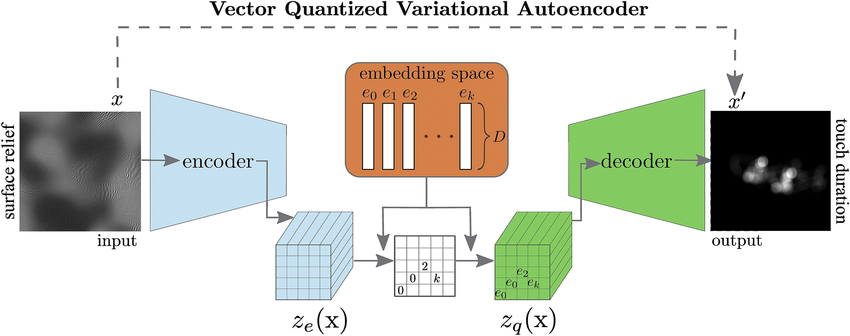


# 코드 흐름

## 1. Class 선언
- class VectorQuantizer

## 2. 함수 선언
- get_encoder
- get_decoder
- get_vqvae

### 3. class VQVAE trainer
- 왜있는걸까?

### 4. 학습 진행

### 5. 생성된 이미지 확인!

In [5]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs): #num_embeddings: K, embedding_dim : D
      super().__init__(**kwargs) #init의 변수들이 keyward argument 형태여도 문제없이 할당이 됨.
      self.embedding_dim = embedding_dim
      self.num_embeddings = num_embeddings
      self.beta = (
          beta # 0.25~2 일떄 제일 좋대요.
      )

      # 우리가 quantize할 embedding을 초기화
      w_init = tf.random_uniform_initializer()
      self.embeddings = tf.Variable(
          initial_value = w_init(
              shape = (self.embedding_dim, self.num_embeddings), dtype="float32"
          ),
          trainable = True,
          name = "embeddings_vqvae"
    )  
    
    def call(self,x):
      # input shape를 계산하고 embedding_dim(D)을 최소화하면서 flatten 하는 메소드
      input_shape = tf.shape(x)
      flattened = tf.reshape(x, [-1, self.embedding_dim]) #flatten

      # Quantization
      encoding_indices = self.get_code_indices(flattened) #
      encodings = tf.one_hot(encoding_indices, self.num_embeddings) #onehot 인코딩
      quantized = tf.matmul(encodings, self.embeddings, transpose_b = True) # 초기화된 값에 elementwise multiplication
      quantized = tf.reshape(quantized, input_shape) # reshape

      # loss function
      commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
      codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
      self.add_loss(commitment_loss + codebook_loss)

      # Straight-through estimator.
      quantized = x + tf.stop_gradient(quantized - x) #stop gradient 함수가 있네? 이 코드는 직접 측정하는 파트. backpropagation에서 stopgradient에 있는 부분은 포함이 안되어요.
      return quantized
    

    def get_code_indices(self, flattened_inputs):
      # input과 codebook vector간 L2 distance 계산하기
      similarity = tf.matmul(flattened_inputs, self.embeddings)
      distances = (
          tf.reduce_sum(flattened_inputs**2, axis=1, keepdims=True)
          +tf.reduce_sum(self.embeddings**2, axis=0)
          -2 * similarity
      )

      encoding_indices = tf.argmin(distances, axis=1)
      return encoding_indices

$$L = log \space p(x|z_q(x)) + ||sg[z_e(x)] - e||_2^2 + ||z_e(x) - sg[e]||_2^2$$


- 1, (Reconstruction Loss) + 2. |codebook loss| +  3. |commitment loss|
- sg : stopgradient operator

### Reconstruction Loss

- Decoder와 encoder를 최적화하는 부분
1. decoder에 의해서 생성된 최종 output에 대한 확률을 log값으로 표현하여 loss 연산

### Codebook loss
**코드북 벡터가 encoder의 벡터가 더 가깝게 되도록 함**

- $z_e$ 로부터 $z_q$ 로의 gradient가 그대로 매핑되기 때문에, $e_k$는 $log \space p(x|z_q(x))$ 로부터 gradient를 받지 않음 (gradient flow로부터 학습 및 update가 안됨)
- **그래서 Vector Quantization를 이용**함

## Encoder와 Decoder를 추가하자

- convolution layer와 conv2d transpose layer를 각각 쌓는 방식

In [6]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

In [7]:
def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder().output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [8]:
def get_vqvae(latent_dim=16, num_embeddings=64): #D=16, K=64 default
    # VectorQuantizer class 여기 활용(vq_layer instance 생성)
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1)) 
    # encoder -> vqvae layer -> decoder
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


## input과 output의 channel은 동일해야 한다는 것을 잊지 말자!

## VQVAE Trainer!

In [10]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


In [11]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)
(60000, 28, 28, 1)
(60000, 28, 28, 1)
(60000, 28, 28, 1)
(60000, 28, 28, 1)


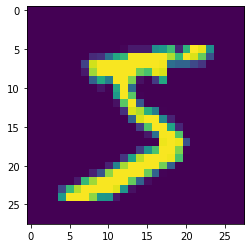

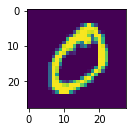

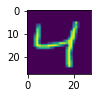

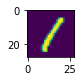

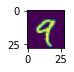

In [25]:
for i in range(5):
  plt.figure()
  plt.subplot(i+1,1,1)
  plt.imshow(x_train[i].reshape(28,28))
  # print(x_train.shape)


## VQ-VAE로 학습진행

In [12]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 11s 7ms/step - loss: 2.8840 - reconstruction_loss: 0.3223 - vqvae_loss: 2.2268
Epoch 2/30
469/469 [==============================] - 3s 6ms/step - loss: 2.1401 - reconstruction_loss: 0.1396 - vqvae_loss: 1.9941
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 1.0291 - reconstruction_loss: 0.1208 - vqvae_loss: 0.9048
Epoch 4/30
469/469 [==============================] - 3s 6ms/step - loss: 0.6904 - reconstruction_loss: 0.1063 - vqvae_loss: 0.5807
Epoch 5/30
469/469 [==============================] - 3s 6ms/step - loss: 0.5114 - reconstruction_loss: 0.0967 - vqvae_loss: 0.4127
Epoch 6/30
469/469 [==============================] - 3s 6ms/step - loss: 0.4334 - reconstruction_loss: 0.0875 - vqvae_loss: 0.3437
Epoch 7/30
469/469 [==============================] - 3s 6ms/step - loss: 0.3724 - reconstruction_loss: 0.0793 - vqvae_loss: 0.2915
Epoch 8/30
469/469 [==============================] - 3s 6ms/step - loss: 0

## VQ-VAE 로 생성된 이미지와 원이미지를 비교해 보자!

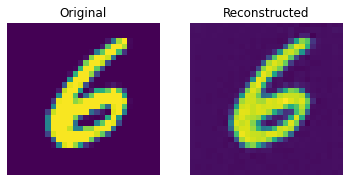

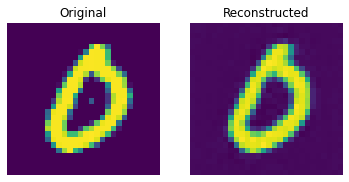

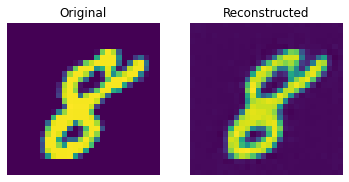

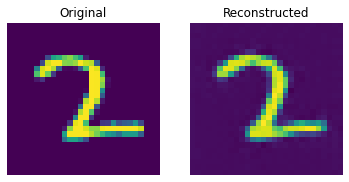

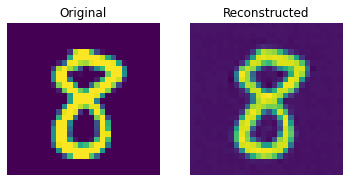

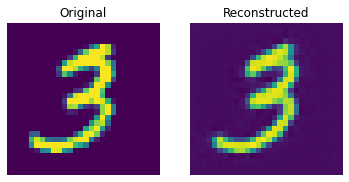

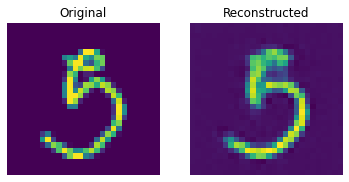

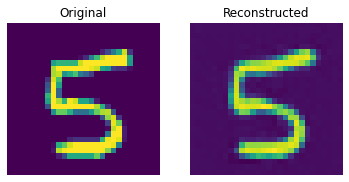

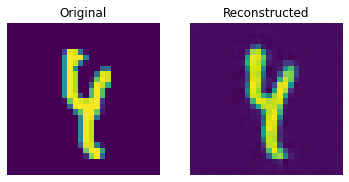

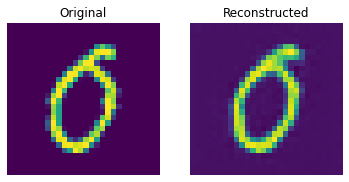

In [26]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

## discrete Code(코드북 벡터)를 시각화해 보자!

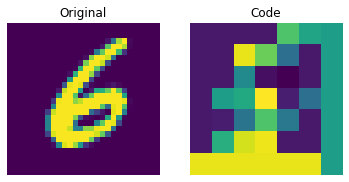

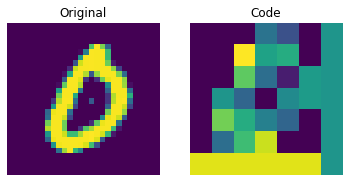

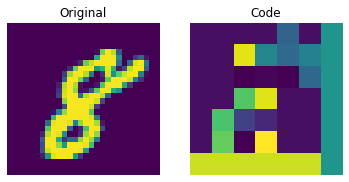

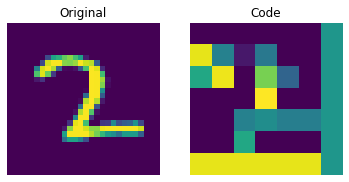

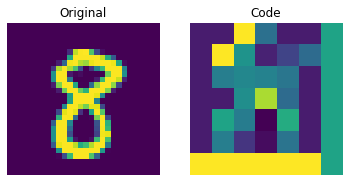

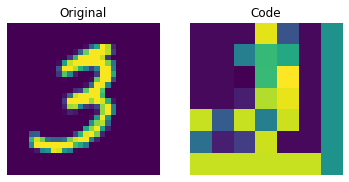

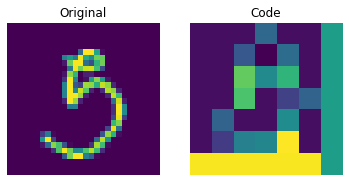

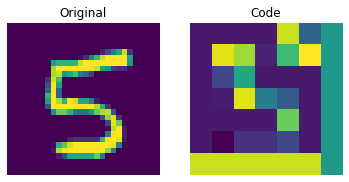

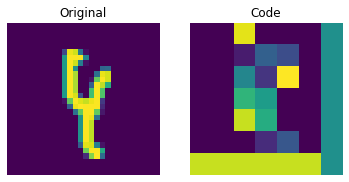

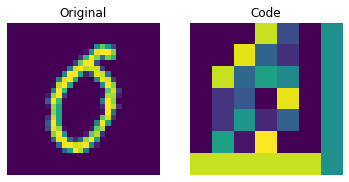

In [27]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

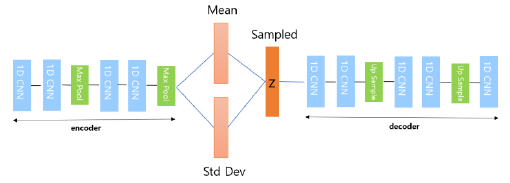

## 위 논문으로부터 encoder decoder 정보를 통해 재구성하여 보자.


In [ ]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

In [ ]:
def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder().output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
def get_vqvae(latent_dim=16, num_embeddings=64): #D=16, K=64 default
    # VectorQuantizer class 여기 활용(vq_layer instance 생성)
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1)) 
    # encoder -> vqvae layer -> decoder
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }
